In [1]:
import pandas as pd # for dataframes
import numpy as np
import matplotlib.pyplot as plt # for simple plots
from sklearn.preprocessing import StandardScaler
import phik
from phik.report import plot_correlation_matrix
from phik import report
import seaborn as sns # for slightly more complicated plots
import numpy as np # for numerical computing and linear algebra data structur
from numba import jit # for JIT compilation facilties for improved efficiency

#### Data Ingestion

DATA DESCRIPTION:<br>
Input features:<br>
Objective: factual information;<br>
Examination: results of medical examination;<br>
Subjective: information given by the patient.<br>

Features:<br>
Age | Objective Feature | age | int (days)<br>
Height | Objective Feature | height | int (cm) |<br>
Weight | Objective Feature | weight | float (kg) |<br>
Gender | Objective Feature | gender | categorical code | 1 - women, 2 - men |<br>
Systolic blood pressure | Examination Feature | ap_hi | int |<br>
Diastolic blood pressure | Examination Feature | ap_lo | int |<br>
Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |<br>
Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |<br>
Smoking | Subjective Feature | smoke | binary | 1-Yes, 0-No<br>
Alcohol intake | Subjective Feature | alco | binary | 1-Yes, 0-No<br>
Physical activity | Subjective Feature | active | binary | 1-Yes, 0-No<br>
Presence or absence of cardiovascular disease | Target Variable | cardio | binary | 1-Yes, 0-No” <br>


In [3]:
#Reading in the data and storing it into a pandas dataframe
df = pd.read_csv('cardio_train 3.csv',sep=';') 

#### Data Pre-Processing

In [64]:
#display first 20 rows
df.head(20)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0


#### Checking for duplicate ids in the dataset

In [65]:
df['id'].value_counts() 
#no duplicates found hence keep all rows

0        1
66623    1
66631    1
66630    1
66628    1
        ..
33338    1
33339    1
33340    1
33341    1
99999    1
Name: id, Length: 70000, dtype: int64

Converting age from number of days to year

In [66]:
df['age'] = (df['age'] / 365.25).astype(int)
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0


#### Data Observation

In [67]:
df.info()
#The data is in an appropriate format and contains all its values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int32  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int32(1), int64(11)
memory usage: 6.7 MB


#### Data imputation to preserve statistical power, avoid bias as much as possible.

In [68]:
def produce_missing_report(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({
                                     'percent_missing': percent_missing})
    return missing_value_df

produce_missing_report(df) #Confirmed no data missing from the rows

,percent_missing
id,0.0
age,0.0
gender,0.0
height,0.0
weight,0.0
ap_hi,0.0
ap_lo,0.0
cholesterol,0.0
gluc,0.0
smoke,0.0


#### Data Standardization to ensure that all features have a similar scale and variance.

In [69]:
def standardize_col(col):
    scaler = StandardScaler()
    std_col = scaler.fit_transform(col.values.reshape(-1, 1))
    return std_col

standardize_col(df['age'])
standardize_col(df['height'])
standardize_col(df['weight'])
standardize_col(df['ap_hi'])
standardize_col(df['ap_lo'])
df.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0


#### Outlier Detection analysis on the age, height, weight, ap_hi, and ap_lo columns, since they are continuous numerical variables that may have outliers.

Performing outlier detection on the age column

In [70]:
df['age'].describe()

count    70000.000000
mean        52.803257
std          6.762462
min         29.000000
25%         48.000000
50%         53.000000
75%         58.000000
max         64.000000
Name: age, dtype: float64

In [71]:
Q1 = df['age'].quantile(0.25)
print("Q1 ", Q1)
Q3 = df['age'].quantile(0.75)
print("Q3 ", Q3)
IQR = Q3 - Q1
print("IQR", IQR)

Q1  48.0
Q3  58.0
IQR 10.0


In [72]:
upper_bound = Q3 + 1.5 * IQR
print("upper ", upper_bound)
lower_bound = Q1 - 1.5 * IQR
print("lower ", lower_bound)

upper  73.0
lower  33.0


In [73]:
df_without_outliers = df[(df['age'] < upper_bound) & (df['age'] > lower_bound)]
df_without_outliers

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,61,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


{'whiskers': [<matplotlib.lines.Line2D at 0x1c31df1a6e0>,
 'caps': [<matplotlib.lines.Line2D at 0x1c31df1ac80>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c31df1a410>],
 'medians': [<matplotlib.lines.Line2D at 0x1c31df1b220>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c31df1b4f0>],
 'means': []}

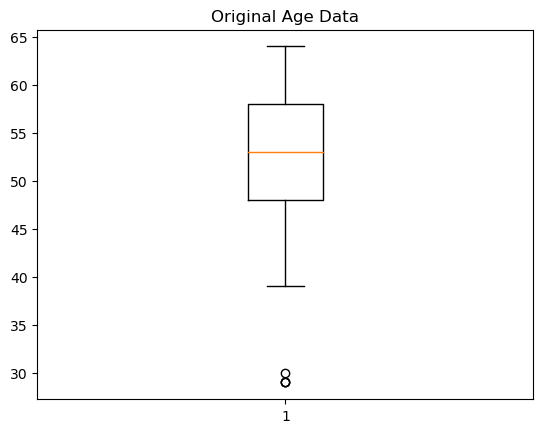

In [74]:
fig1, ax1 = plt.subplots()
ax1.set_title('Original Age Data')
ax1.boxplot(df['age'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1c31df60970>,
 'caps': [<matplotlib.lines.Line2D at 0x1c31df60f10>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c31df606a0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c31df614b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c31df61780>],
 'means': []}

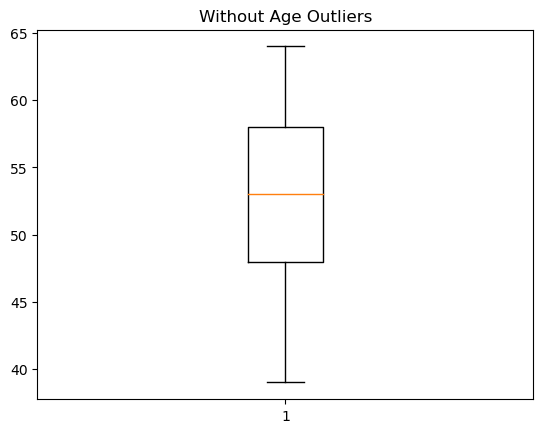

In [75]:
fig1, ax1 = plt.subplots()
ax1.set_title('Without Age Outliers')
ax1.boxplot(df_without_outliers['age'])

In [76]:
df_without_outliers = df[(df['age'] > lower_bound) & (df['age'] < upper_bound)].reset_index(drop=True)
df = df_without_outliers
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69991,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69992,99995,61,1,158,126.0,140,90,2,2,0,0,1,1
69993,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69994,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


Performing outlier detection on the height column

In [77]:
df['height'].describe() # uncertain of if this is needed, people have varied height doesnt mean it contributes to CVD. however the column continuous. do correlation matrix to see the relevance

count    69996.000000
mean       164.359063
std          8.210122
min         55.000000
25%        159.000000
50%        165.000000
75%        170.000000
max        250.000000
Name: height, dtype: float64

In [79]:
Q1 = df['height'].quantile(0.25)
print("Q1 ", Q1)
Q3 = df['height'].quantile(0.75)
print("Q3 ", Q3)
IQR = Q3 - Q1
print("IQR", IQR)

Q1  159.0
Q3  170.0
IQR 11.0


In [80]:
upper_bound = Q3 + 1.5 * IQR
print("upper ", upper_bound)
lower_bound = Q1 - 1.5 * IQR
print("lower ", lower_bound)

upper  186.5
lower  142.5


In [81]:
df_without_outliers = df[(df['height'] < upper_bound) & (df['height'] > lower_bound)]
df_without_outliers

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69991,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69992,99995,61,1,158,126.0,140,90,2,2,0,0,1,1
69993,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69994,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


{'whiskers': [<matplotlib.lines.Line2D at 0x1c31dfad930>,
 'caps': [<matplotlib.lines.Line2D at 0x1c31dfaded0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c31dfad660>],
 'medians': [<matplotlib.lines.Line2D at 0x1c31dfae470>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c31dfae740>],
 'means': []}

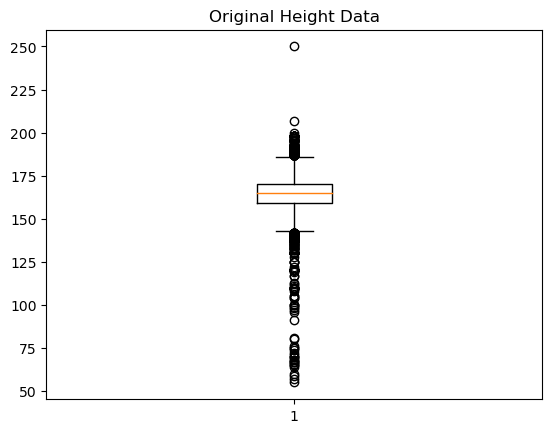

In [82]:
fig1, ax1 = plt.subplots()
ax1.set_title('Original Height Data')
ax1.boxplot(df['height'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1c31f7e4340>,
 'caps': [<matplotlib.lines.Line2D at 0x1c31f7e48e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c31f7e4070>],
 'medians': [<matplotlib.lines.Line2D at 0x1c31f7e4e80>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c31f7e5150>],
 'means': []}

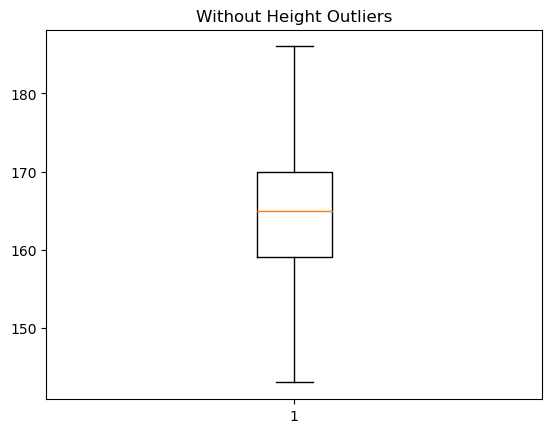

In [83]:
fig1, ax1 = plt.subplots()
ax1.set_title('Without Height Outliers')
ax1.boxplot(df_without_outliers['height'])

In [84]:
df_without_outliers = df[(df['height'] > lower_bound) & (df['height'] < upper_bound)].reset_index(drop=True)
df = df_without_outliers
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69472,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69473,99995,61,1,158,126.0,140,90,2,2,0,0,1,1
69474,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69475,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


Performing outlier detection on the weight column

In [23]:
df['weight'].describe()

count    18.000000
mean     67.144444
std       7.145482
min      57.000000
25%      61.000000
50%      68.000000
75%      71.750000
max      81.000000
Name: weight, dtype: float64

In [85]:
Q1 = df['weight'].quantile(0.25)
print("Q1 ", Q1)
Q3 = df['weight'].quantile(0.75)
print("Q3 ", Q3)
IQR = Q3 - Q1
print("IQR", IQR)

Q1  65.0
Q3  82.0
IQR 17.0


In [86]:
upper_bound = Q3 + 1.5 * IQR
print("upper ", upper_bound)
lower_bound = Q1 - 1.5 * IQR
print("lower ", lower_bound)

upper  107.5
lower  39.5


In [87]:
df_without_outliers = df[(df['weight'] < upper_bound) & (df['weight'] > lower_bound)]
df_without_outliers

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69471,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
69472,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69474,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69475,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


{'whiskers': [<matplotlib.lines.Line2D at 0x1c31f839480>,
 'caps': [<matplotlib.lines.Line2D at 0x1c31f839a20>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c31f8391b0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c31f839fc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c31f83a290>],
 'means': []}

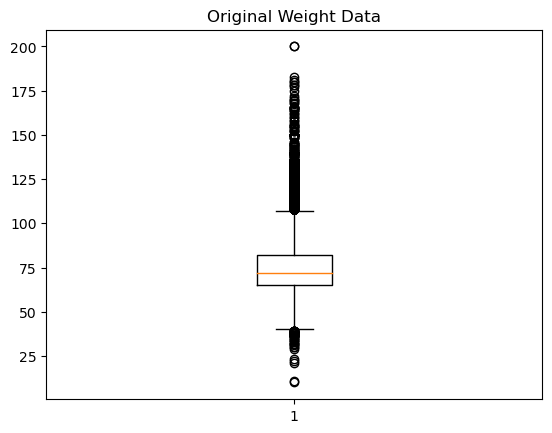

In [88]:
fig1, ax1 = plt.subplots()
ax1.set_title('Original Weight Data')
ax1.boxplot(df['weight'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1c31f887940>,
 'caps': [<matplotlib.lines.Line2D at 0x1c31f887ee0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c31f887670>],
 'medians': [<matplotlib.lines.Line2D at 0x1c31f8b44c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c31f8b4790>],
 'means': []}

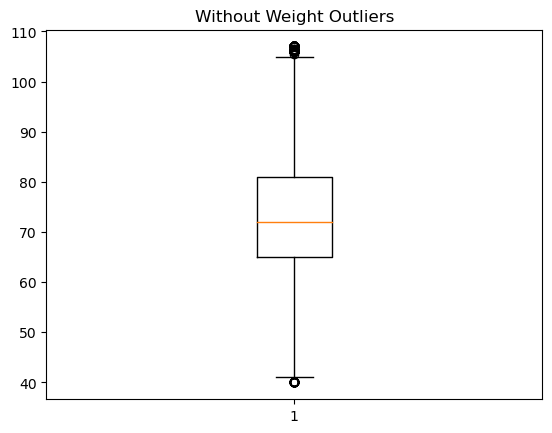

In [89]:
fig1, ax1 = plt.subplots()
ax1.set_title('Without Weight Outliers')
ax1.boxplot(df_without_outliers['weight'])

In [90]:
df_without_outliers = df[(df['weight'] > lower_bound) & (df['weight'] < upper_bound)].reset_index(drop=True)
df = df_without_outliers
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67714,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
67715,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
67716,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
67717,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


Performing outlier detection on the ap_hi column

In [91]:
df['ap_hi'].describe()

count    67719.000000
mean       128.585951
std        156.528328
min       -150.000000
25%        120.000000
50%        120.000000
75%        140.000000
max      16020.000000
Name: ap_hi, dtype: float64

In [92]:
Q1 = df['ap_hi'].quantile(0.25)
print("Q1 ", Q1)
Q3 = df['ap_hi'].quantile(0.75)
print("Q3 ", Q3)
IQR = Q3 - Q1
print("IQR", IQR)

Q1  120.0
Q3  140.0
IQR 20.0


In [93]:
upper_bound = Q3 + 1.5 * IQR
print("upper ", upper_bound)
lower_bound = Q1 - 1.5 * IQR
print("lower ", lower_bound)

upper  170.0
lower  90.0


In [94]:
df_without_outliers = df[(df['ap_hi'] < upper_bound) & (df['ap_hi'] > lower_bound)]
df_without_outliers

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67713,99991,53,1,172,70.0,130,90,1,1,0,0,1,1
67714,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
67715,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
67717,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


{'whiskers': [<matplotlib.lines.Line2D at 0x1c320602200>,
 'caps': [<matplotlib.lines.Line2D at 0x1c3206027a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c320601ed0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c320602d40>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c320602fb0>],
 'means': []}

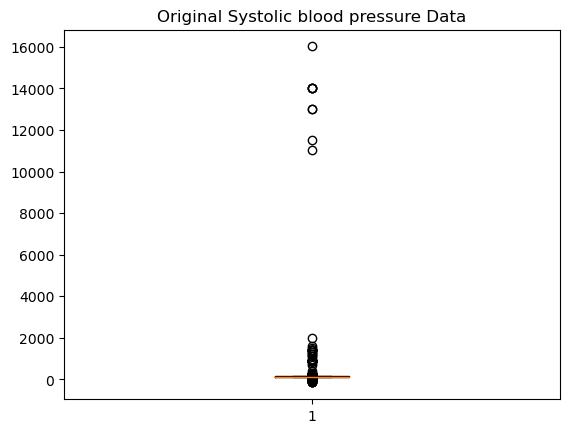

In [95]:
fig1, ax1 = plt.subplots()
ax1.set_title('Original Systolic blood pressure Data')
ax1.boxplot(df['ap_hi'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1c320678bb0>,
 'caps': [<matplotlib.lines.Line2D at 0x1c320679150>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c3206788e0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c3206796f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c3206799c0>],
 'means': []}

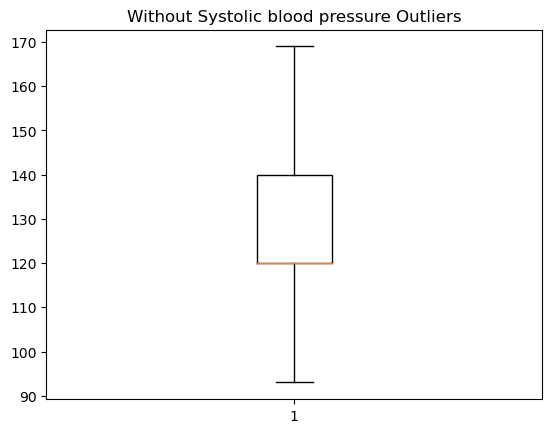

In [96]:
fig1, ax1 = plt.subplots()
ax1.set_title('Without Systolic blood pressure Outliers')
ax1.boxplot(df_without_outliers['ap_hi'])

In [97]:
df_without_outliers = df[(df['ap_hi'] > lower_bound) & (df['ap_hi'] < upper_bound)].reset_index(drop=True)
df = df_without_outliers
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64798,99991,53,1,172,70.0,130,90,1,1,0,0,1,1
64799,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
64800,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
64801,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


Performing outlier detection on the ap_lo column

In [98]:
df['ap_lo'].describe()

count    64803.000000
mean        93.685107
std        181.503375
min          0.000000
25%         80.000000
50%         80.000000
75%         90.000000
max      10000.000000
Name: ap_lo, dtype: float64

In [99]:
Q1 = df['ap_lo'].quantile(0.25)
print("Q1 ", Q1)
Q3 = df['ap_lo'].quantile(0.75)
print("Q3 ", Q3)
IQR = Q3 - Q1
print("IQR", IQR)

Q1  80.0
Q3  90.0
IQR 10.0


In [100]:
upper_bound = Q3 + 1.5 * IQR
print("upper ", upper_bound)
lower_bound = Q1 - 1.5 * IQR
print("lower ", lower_bound)

upper  105.0
lower  65.0


In [101]:
df_without_outliers = df[(df['ap_lo'] < upper_bound) & (df['ap_lo'] > lower_bound)]
df_without_outliers

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
5,8,59,1,151,67.0,120,80,2,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64798,99991,53,1,172,70.0,130,90,1,1,0,0,1,1
64799,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
64800,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
64801,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


{'whiskers': [<matplotlib.lines.Line2D at 0x1c3206c7940>,
 'caps': [<matplotlib.lines.Line2D at 0x1c3206c7ee0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c3206c7670>],
 'medians': [<matplotlib.lines.Line2D at 0x1c3204b04c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c3204b0790>],
 'means': []}

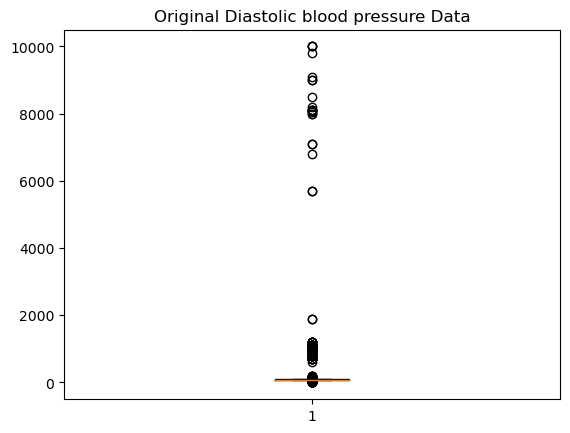

In [102]:
fig1, ax1 = plt.subplots()
ax1.set_title('Original Diastolic blood pressure Data')
ax1.boxplot(df['ap_lo'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1c3204fd3c0>,
 'caps': [<matplotlib.lines.Line2D at 0x1c3204fd960>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c3204fd0f0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c3204fdf00>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c3204fe1d0>],
 'means': []}

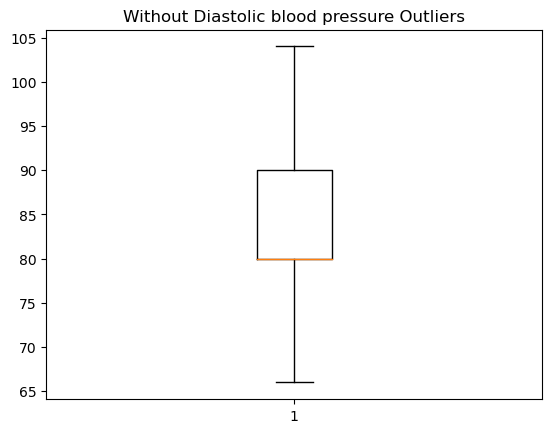

In [103]:
fig1, ax1 = plt.subplots()
ax1.set_title('Without Diastolic blood pressure Outliers')
ax1.boxplot(df_without_outliers['ap_lo'])

In [104]:
df_without_outliers = df[(df['ap_lo'] > lower_bound) & (df['ap_lo'] < upper_bound)].reset_index(drop=True)
df = df_without_outliers
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,8,59,1,151,67.0,120,80,2,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61766,99991,53,1,172,70.0,130,90,1,1,0,0,1,1
61767,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
61768,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
61769,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


## EDA

Non-Modifiable Cause:

Old Age
Heridity
Gender Factor such as Male

Modifiable Cause: 
Alcohol
Smoking
Physical activity


## Univariate 


In [4]:
df.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

In [5]:
# to understand variables look at their datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


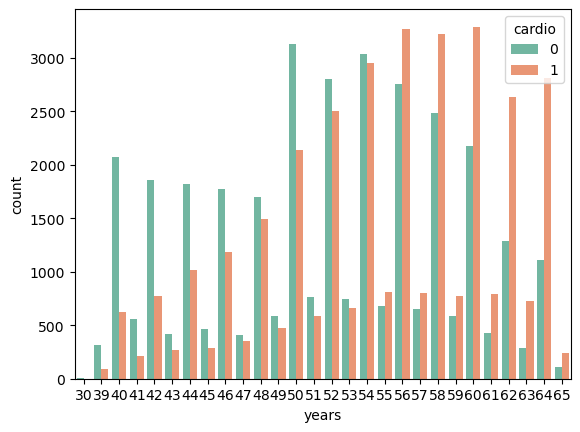

In [7]:
df['years']=(df['age']/365).round().astype(int)
#df['years']
sns.countplot(x='years', hue='cardio', data = df, palette="Set2");
#This plot has shown that CVD is more prevelant in patients who are older

In [8]:
df.describe()
#displays statistics such as min, max, mean, std

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,years
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700,53.338686
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003,6.765294
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,30.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,54.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,65.000000


In [ ]:
plt.figure(1) 
data['gender'].value_counts(normalize=True).plot.bar(title= 'gender') 
plt.show()

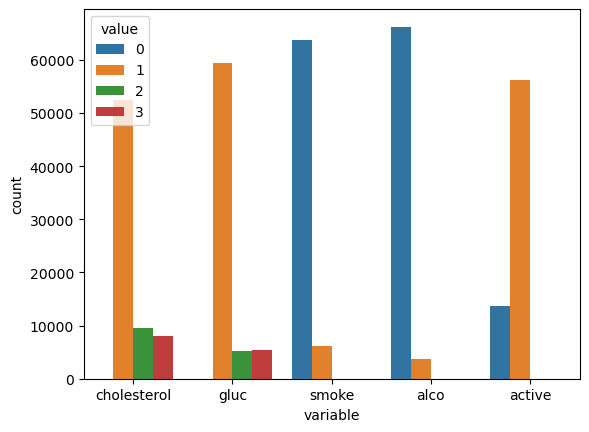

In [9]:
df_categorical = df.loc[:,['cholesterol','gluc', 'smoke', 'alco', 'active']]
sns.countplot(x="variable", hue="value",data= pd.melt(df_categorical));
# this shows the socioeconomic factors that affect patients (some attributes that may lead to cvd)

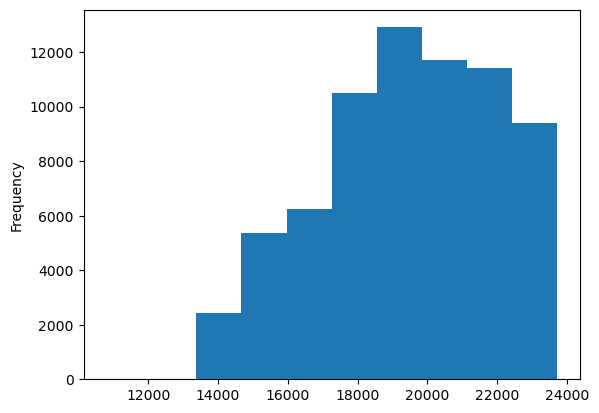

In [56]:
df['age'].plot(kind='hist');
#distribution of age in terms of days in this dataset

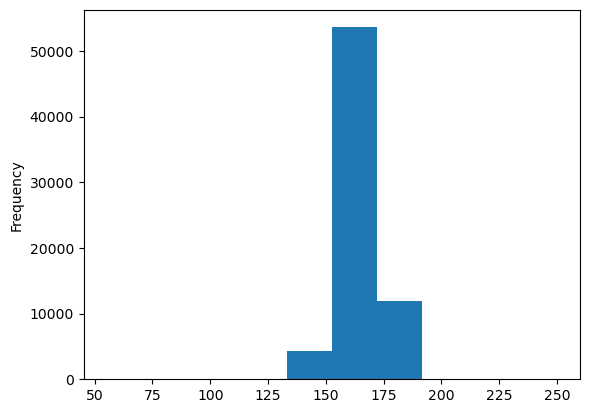

In [59]:
df['height'].plot(kind='hist');
# patients in this dataset were avg 150-175 in height

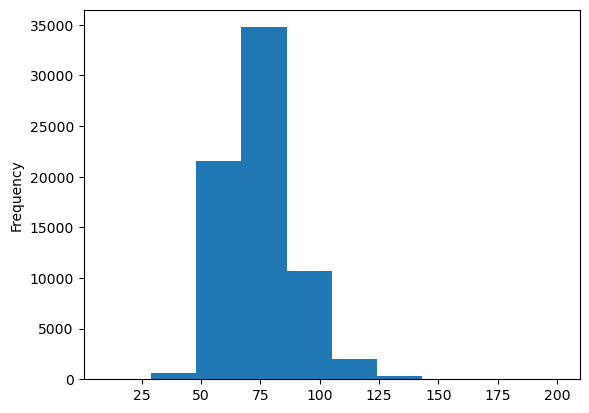

In [60]:
df['weight'].plot(kind='hist');
#patients in this dataset (were mainly 50-80 in weight)

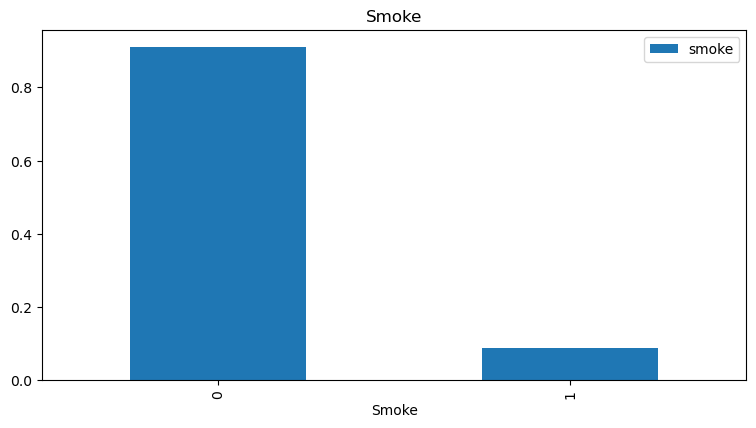

In [18]:
plt.figure(1) 

plt.subplot(221)
df['smoke'].value_counts(normalize=True).plot.bar(figsize=(20,10), title= 'Smoke') 
plt.xlabel('Smoke')
# plt.title ('Distribution of Smoke')
plt.legend()
plt.show()

# Patients who smoke are at higher risk of getting CVD

<AxesSubplot:ylabel='alco'>

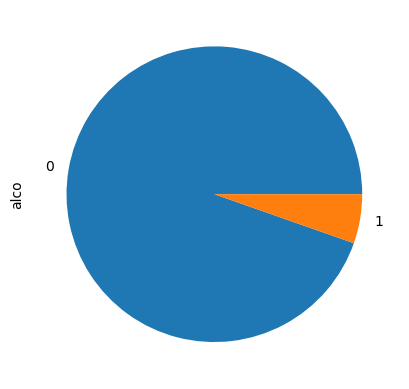

In [39]:
df["alco"].value_counts().plot(kind='pie')
# however, most of the patients in the dataset are seen to be non alcoholics  

c:\Users\Divya\anaconda3\envs\divya_env\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\Users\Divya\anaconda3\envs\divya_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


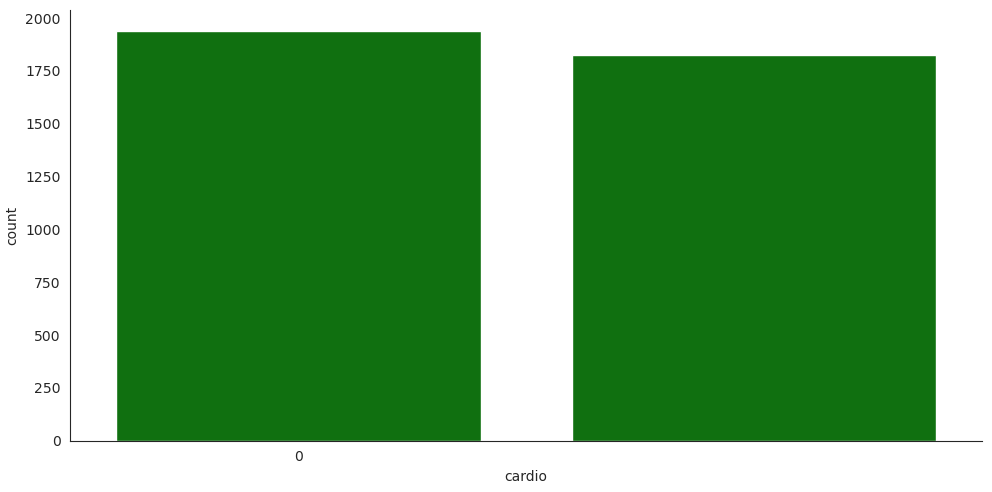

In [48]:
df_alco = df.loc[df["alco"] == 1]
with sns.axes_style('white'):
    g = sns.factorplot("cardio", data=df_alco, aspect=2,
                       kind="count", color='green')
    g.set_xticklabels(step=5)
    #alcohol consumption does not seem to be increase CVD

<AxesSubplot:ylabel='active'>

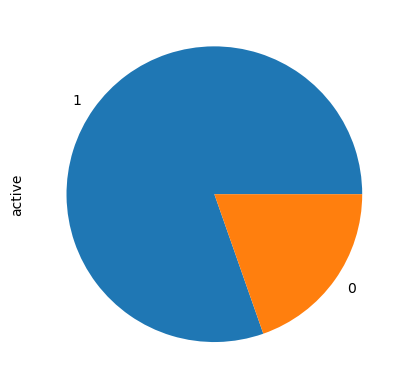

In [42]:
df["active"].value_counts().plot(kind='pie')
#most of the patients in the dataset are seen to be more physically active than inactive

c:\Users\Divya\anaconda3\envs\divya_env\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\Users\Divya\anaconda3\envs\divya_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


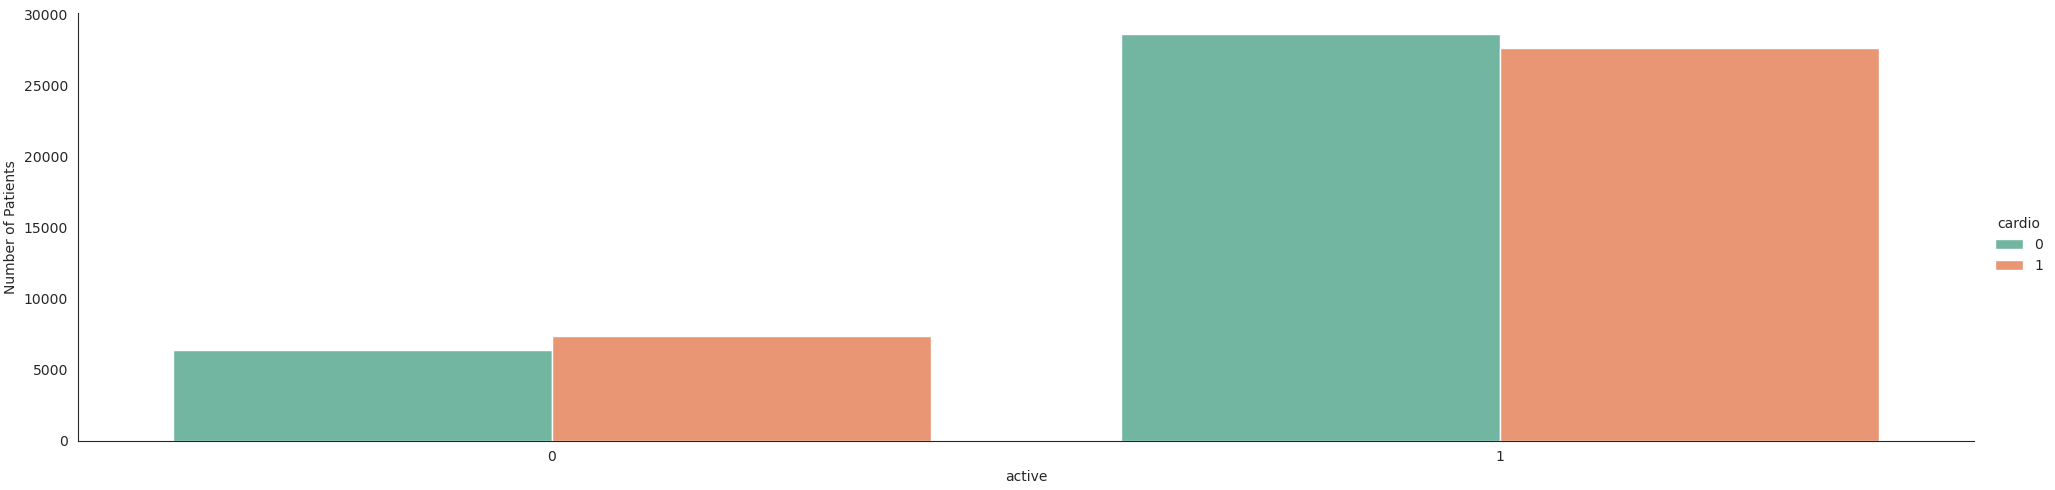

In [53]:
with sns.axes_style('white'):
    g = sns.factorplot("active", data=df, aspect=4.0, kind='count',
                       hue='cardio', palette="Set2")
    g.set_ylabels('Number of Patients')
    #The physically active patients are less at risk to CVD

<AxesSubplot:ylabel='smoke'>

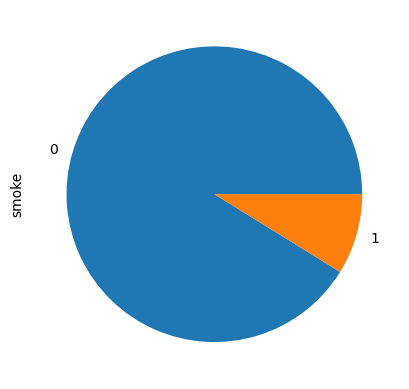

In [50]:
df["smoke"].value_counts().plot(kind='pie')
There are more non-smokers in this dataset

c:\Users\Divya\anaconda3\envs\divya_env\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\Users\Divya\anaconda3\envs\divya_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


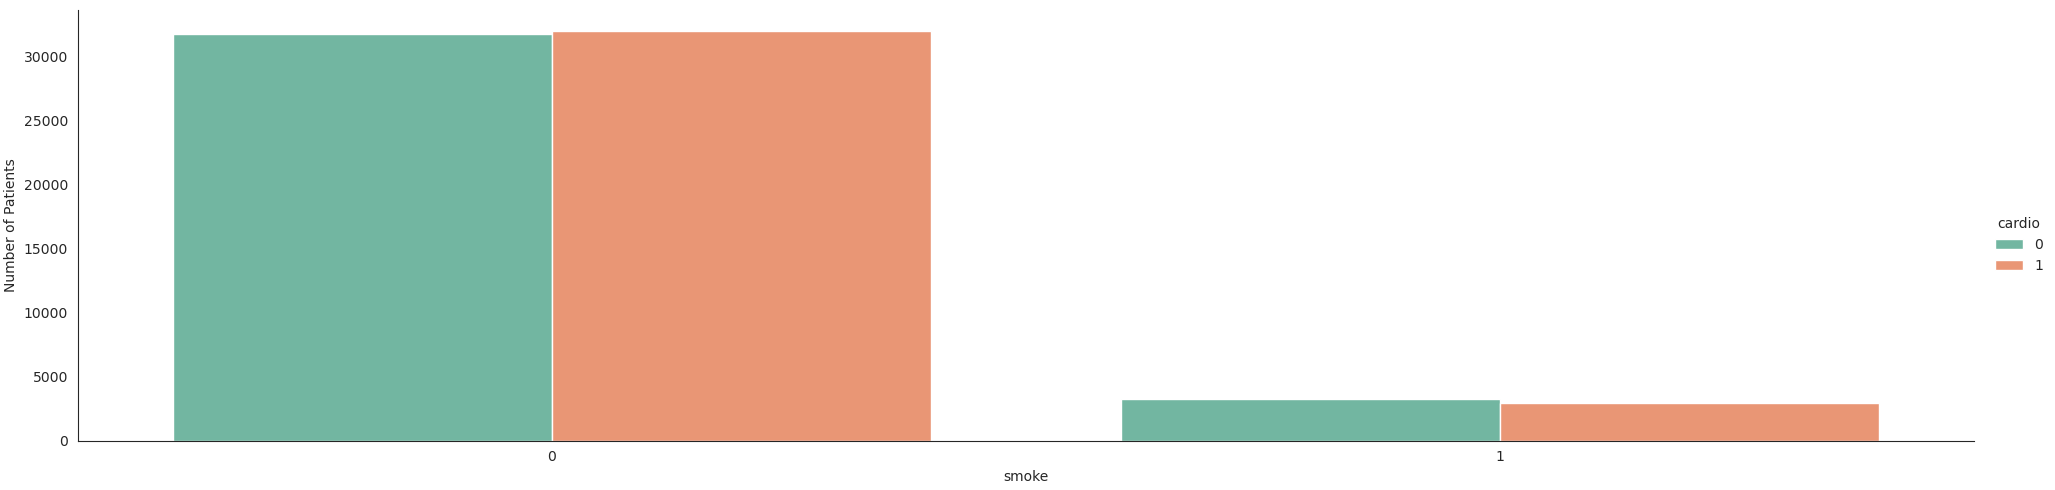

In [51]:
with sns.axes_style('white'):
    g = sns.factorplot("smoke", data=df, aspect=4.0, kind='count',
                       hue='cardio', palette="Set2")
    g.set_ylabels('Number of Patients')
    #Patients who are non smokers are seen to be more prone to CVD

## Bivariate

In [10]:
df.groupby('gender')['height'].mean()
#Since men tend to be taller tham women, 2 will be assumed to be men.
# 1 : women , 2: men

gender
1    161.355612
2    169.947895
Name: height, dtype: float64

In [11]:
df['gender'].value_counts()

1    45530
2    24470
Name: gender, dtype: int64

In [12]:
df.groupby('gender')['gluc'].sum()
#women have higher glucose level on avg

gender
1    56232
2    29620
Name: gluc, dtype: int64

In [13]:
df.groupby('gender')['cholesterol'].sum()
#women have higher cholesterol on avg

gender
1    63047
2    32634
Name: cholesterol, dtype: int64

In [15]:
df.groupby('gender')['smoke'].sum()
#men are more smokers on avg

gender
1     813
2    5356
Name: smoke, dtype: int64

In [16]:
df.groupby('gender')['alco'].sum()
# men drink more alcohol than women on avg

gender
1    1161
2    2603
Name: alco, dtype: int64

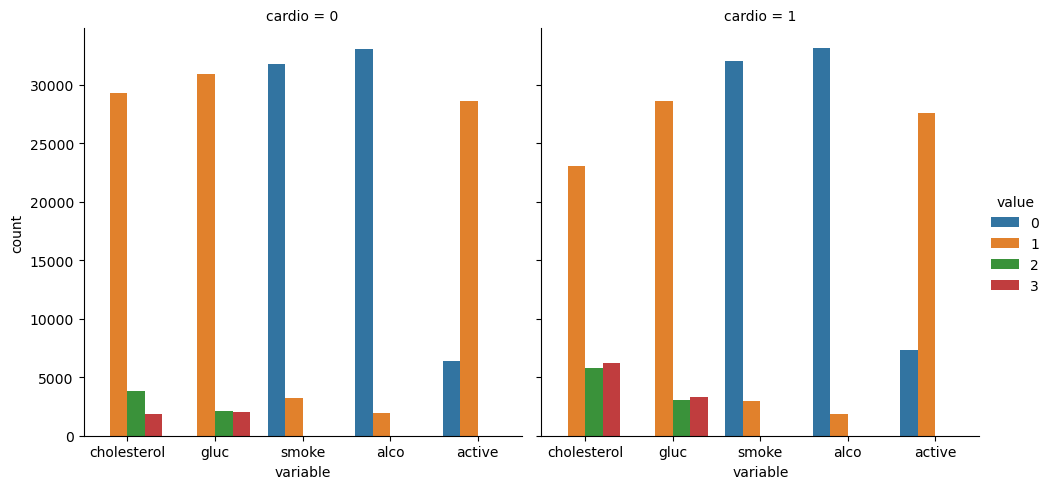

In [24]:
data1 = pd.melt(df, id_vars=['cardio'], value_vars=['cholesterol','gluc', 'smoke', 'alco', 'active'])
sns.catplot(x="variable", hue="value",col="cardio",data= data_long,kind="count");
# this shows that patients who have high cholesterol and high glucose level are more prone to have CVD

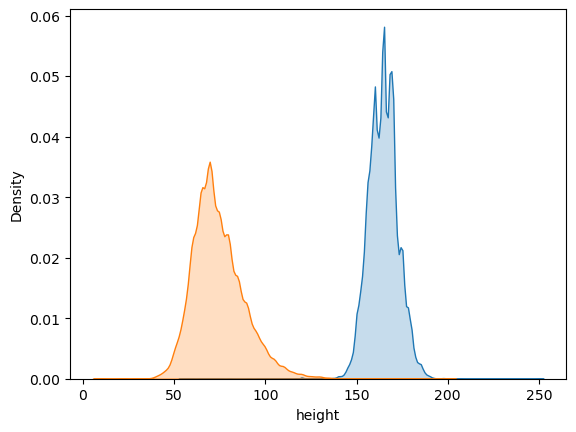

In [30]:
for col in ["height", "weight"]:
    sns.kdeplot(df[col], shade=True)

## Multivariate

In [25]:
#Calculate correlations
corr = df.corr()
#covariance matrix tell us how one feature varies to the other one 

C:\Users\Divya\AppData\Local\Temp\ipykernel_15020\2427925021.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  create = np.zeros_like(corr, dtype=np.bool)


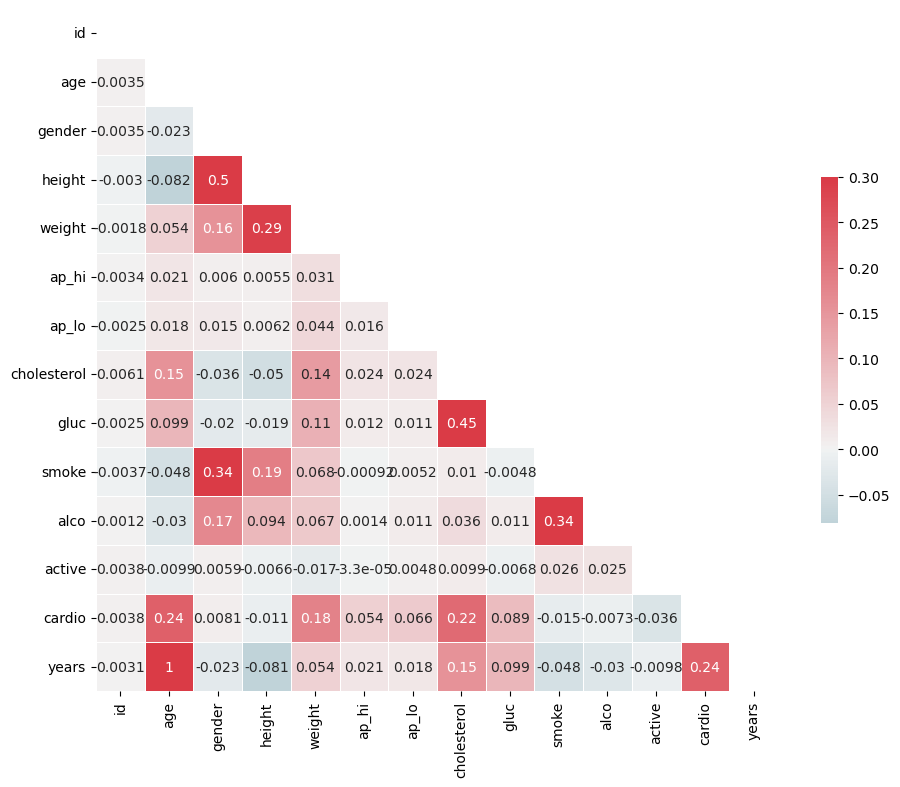

In [28]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
create = np.zeros_like(corr, dtype=np.bool)
create[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

<AxesSubplot:>

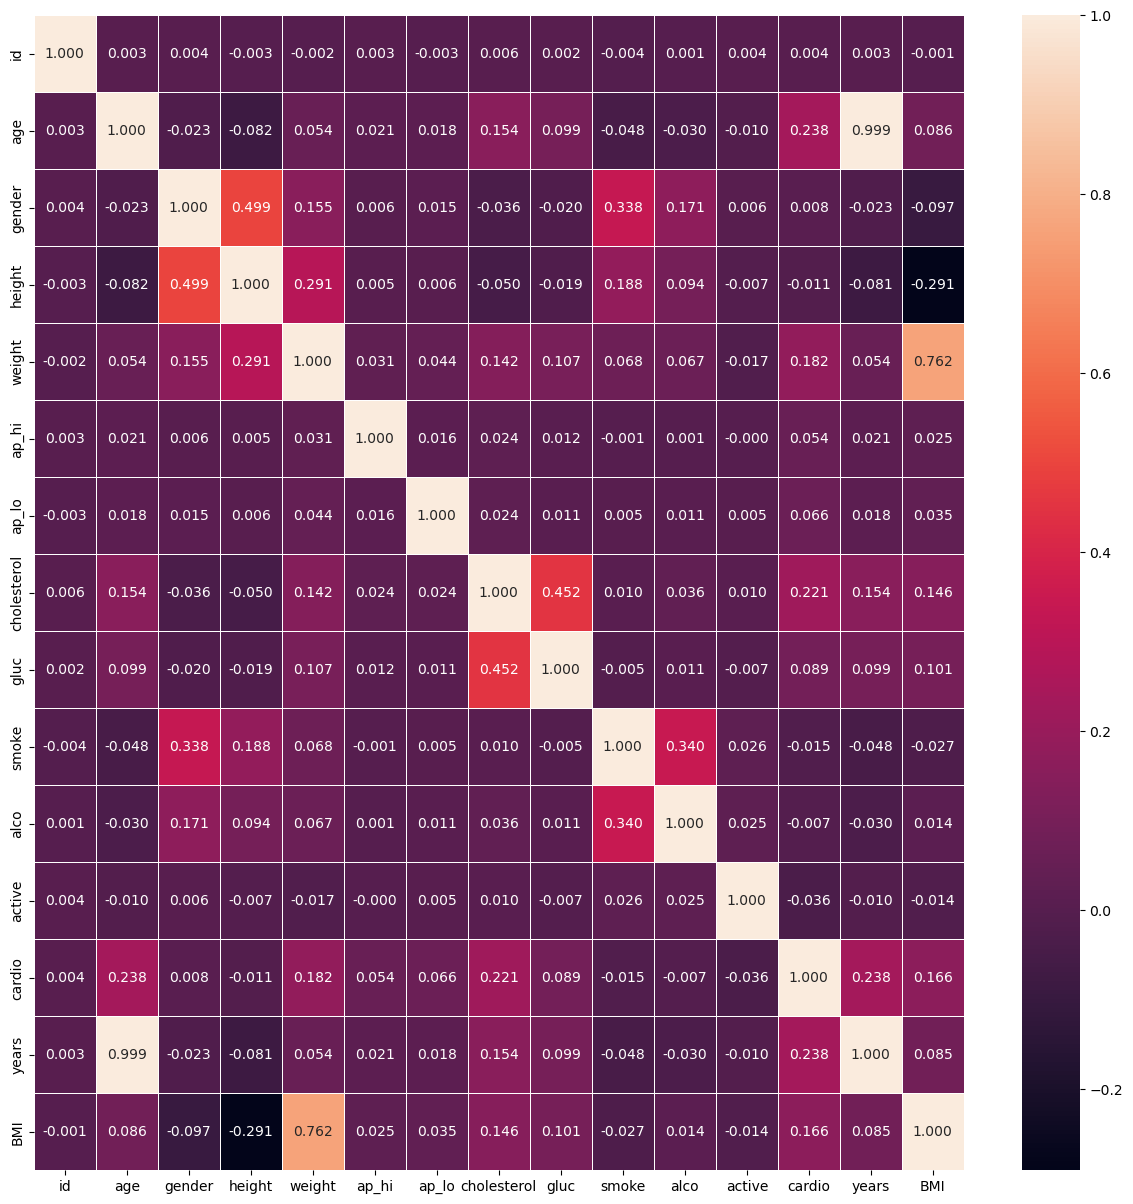

In [44]:
corr = df.corr()
f, ax = plt.subplots(figsize = (15,15))
sns.heatmap(corr, annot=True, fmt=".3f", linewidths=0.5, ax=ax)

From the heatmap, the weight, age and cholestrol seem to have the highest correlation with respect to our target variable(cardio). There is a correlation between weight, age and cholesterol?. Being overweight or obese tends to increase bad cholesterol and lower good cholesterol. Aging also causes cholesterol to increase. 

Cholesterol and glucose have a high correlation, whcih makes sense due to studies which show that elevated blood glucose levels (any type of diabetes) poses a risk of higher cholesterol, manifesting as diabetic dyslipidemia.

Calculating the BMI

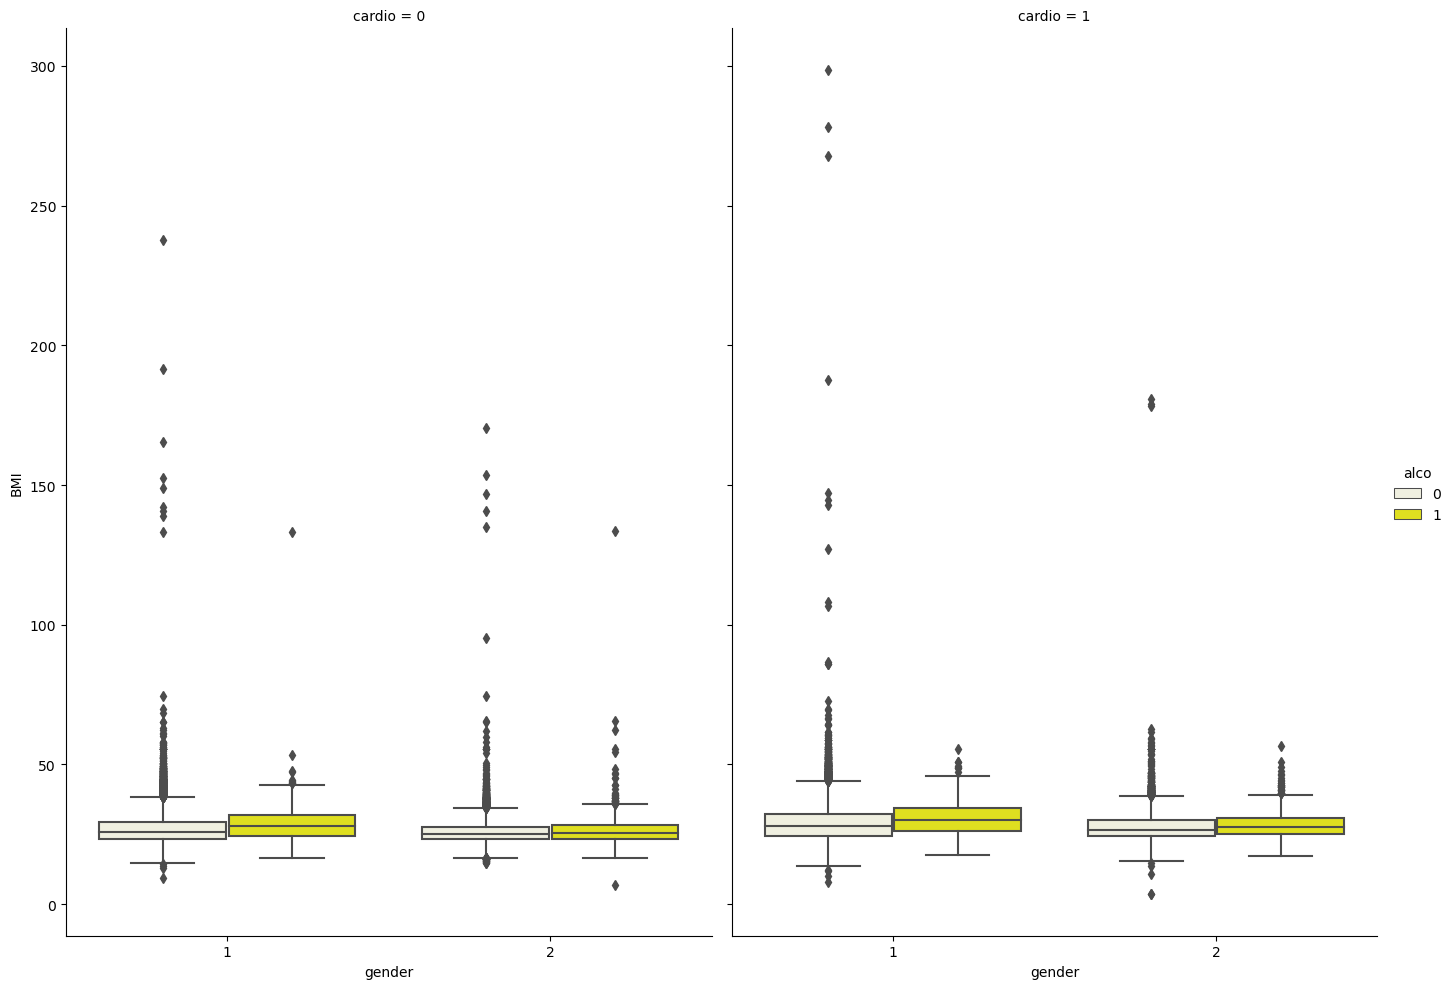

In [29]:
df['BMI'] = df['weight']/((df['height']/100)**2)
sns.catplot(x="gender", y="BMI", hue="alco", col="cardio", data=df, color = "yellow",kind="box", height=10, aspect=.7);

<AxesSubplot:ylabel='BMI_State'>

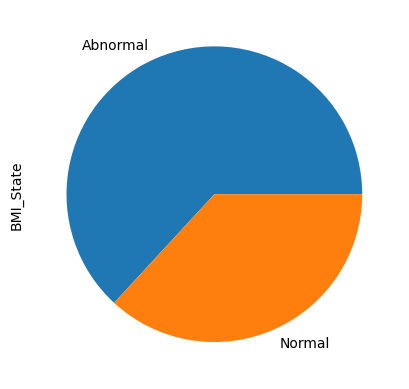

In [33]:
# determining normal & abnormal BMI
def bmi(bmi_num):
  if 18.5 <= bmi_num <= 25:
    return "Normal"
  else:
    return "Abnormal"

df["BMI_State"] = df["BMI"].apply(lambda x: bmi(x))
df["BMI_State"].value_counts().plot(kind='pie')

#There was a higher rate of abnormal BMI than normal

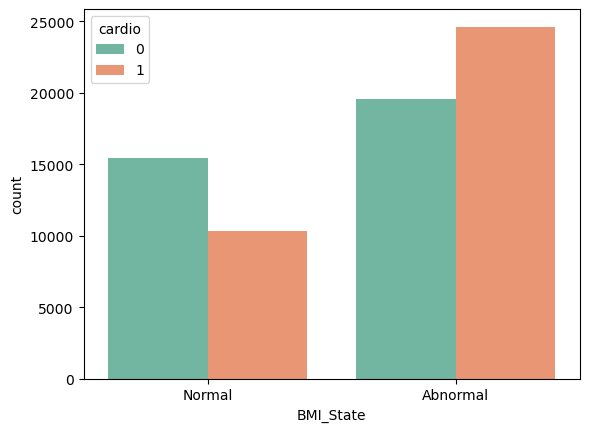

In [35]:
sns.countplot(x='BMI_State', hue='cardio', data = df, palette="Set2");
##patients with abnormal BMI are more prone to CVD

## Feature

The features that are prominently shown to lead to CSV are non-smokers, those with high cholesterol, high glucose level and older patients. 